In [7]:
import uproot
import numpy as np
import torch
import jax.numpy as jnp
import jraph
import jax.random as jrandom
import jax.tree_util as tree
import jax
import flax 
import haiku as hk
from typing import Any, Callable, Dict, List, Optional, Tuple
import optax
import os
import itertools
import matplotlib.pyplot as plt 
from jraph._src import models
import tqdm
from jax.experimental.host_callback import call



from jax.lib import xla_bridge
print('Using platform: ', xla_bridge.get_backend().platform)

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".10"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

arrays = np.load('/home/lrambelli/patternreco/arrays_layer_nhit.npy', allow_pickle = True)
X_nhit = arrays[0]  #96493
Y_nhit = arrays[1]
Z_nhit = arrays[2]
ID_nhit = arrays[3]


start_training = 0
end_training= 6400
batch_size = 32
lr = 1e-3
steps = 150

#arrays = np.asarray((xx[start_training:end_training], yy[start_training:end_training], zz[start_training:end_training], idid[start_training:end_training]))
#print('Events for training: ', arrays.shape[0])

arrays_training = np.asarray((X_nhit[start_training:end_training], Y_nhit[start_training:end_training], Z_nhit[start_training:end_training], ID_nhit[start_training:end_training]))

print('n events for training: ', arrays_training.shape)
#start_test = end_training + 1
#end_test= start_test + 100
start_test = start_training
end_test = end_training

arrays_test = np.asarray((X_nhit[start_test:end_test], Y_nhit[start_test:end_test], Z_nhit[start_test:end_test], ID_nhit[start_test:end_test]))
print('Events for testing: ',  arrays_test.shape)


## functions for graph creation ##

#function that compute the node number (hit number) for each graph (event) in the batch
def get_node_number(arrays, batch_size):
    node_numbers = []
    x = arrays[0]
    
    for i in range(batch_size):
        
        xx = x[i]
        node_numbers.append([xx.shape[0]])
    max_value = np.max(node_numbers)
    #max_value = 384
    
    return node_numbers, max_value

#function that returns the n_nodes and n_edges vectors required for defining the GraphTuple
#n_nodes vector is like ([a],[b],[c]) with a,b,c nodes numbers for each graph in the batch
#n_edges vector is like ([a**2], [b**2], [c**2]) where each element is the number of edges for the graph (fully connected)

def get_nodes_edges_per_event(arrays, batch_size):
    data_array = get_node_number(arrays, batch_size)[0]

    hits_per_event = data_array
    edges_per_event = [[nhits[0]**2] for nhits in data_array]
    return hits_per_event, edges_per_event


#function that creates for each graoh in the batch the vectors defining senders and receivers
#explicitly batched graph is used so all the vectors are padded to the dimension of the bigger one 

def create_senders_receivers(arrays, batch_size):
    #nhits = get_nodes_edges_per_event(arrays, batch_size)[0]
    nhits = get_nodes_edges_per_event(arrays, batch_size)[0]
    senders = []
    receivers = []
    for nhit in nhits:
        n = nhit[0]
        s = torch.arange(n).repeat(n).tolist()
        r = torch.repeat_interleave(torch.arange(n), n).tolist()
        
        senders.append(s)
        receivers.append(r)

    padded_senders = []
    padded_receivers = []
    #max_value = 384
    max_value = get_node_number(arrays, batch_size)[1]

    for sender in senders:
        pad_s = sender + [-1] * (max_value**2 - len(sender))
        padded_senders.append(pad_s)

    for receiver in receivers:
        pad_r = receiver + [-1] * (max_value**2 - len(receiver))
        padded_receivers.append(pad_r)

    return padded_senders, padded_receivers


#function that decorates the target nodes with only the particle id (muon == -13.)
def decorate_nodes_truth(arrays, batch_size):
    nodes = []
    #max_value = 384
    max_value = get_node_number(arrays, batch_size)[1]    
    
    for i in range (0, batch_size):        
        id = np.asarray(arrays[3][i])
        id = jnp.where(jnp.absolute(id) == 13, 1, 0) #for bce

        padded_id =  jnp.pad(id, (0, max_value - len(id)), mode='constant')
        node_features = jnp.stack((padded_id), axis=-1) 
        nodes.append(node_features)

    return nodes

#function that decorates the input nodes with (y,z) coordinates
def decorate_nodes(arrays,batch_size):
    nodes = []
    max_value = get_node_number(arrays, batch_size)[1]   
    #max_value = 384 
    for i in range (0, batch_size):
        y = np.asarray(arrays[1][i])
        z = np.asarray(arrays[2][i])
        padded_y =  jnp.pad(y, (0, max_value - len(y)), mode='constant')
        padded_z =  jnp.pad(z, (0, max_value - len(z)), mode='constant')
      
        node_features = jnp.stack((padded_y,padded_z), axis=-1)
        nodes.append(node_features)

    return nodes

def GetGraphs(arrays: np.ndarray, batch_size : int) -> jraph.GraphsTuple:
    graph = jraph.GraphsTuple(
        n_node=jnp.array(get_nodes_edges_per_event(arrays, batch_size)[0]), 
        n_edge=jnp.array(get_nodes_edges_per_event(arrays, batch_size)[1]), 
        nodes=jnp.array(decorate_nodes(arrays, batch_size)), 
        edges=None, 
        globals=None,  
        senders=jnp.array(create_senders_receivers(arrays, batch_size)[0]), 
        receivers=jnp.array(create_senders_receivers(arrays, batch_size)[1]))
    
    graph_truth = jraph.GraphsTuple(
        n_node=jnp.array(get_nodes_edges_per_event(arrays, batch_size)[0]), 
        n_edge=jnp.array(get_nodes_edges_per_event(arrays, batch_size)[1]), 
        nodes=jnp.array(decorate_nodes_truth(arrays, batch_size)), 
        edges=None, 
        globals=None,  
        senders=jnp.array(create_senders_receivers(arrays, batch_size)[0]), 
        receivers=jnp.array(create_senders_receivers(arrays, batch_size)[1]))
    
    return (graph, graph_truth)


## network definition ##

from jraph._src import utils

def add_self_edges_fn(receivers: jnp.ndarray, senders: jnp.ndarray,
                      total_num_nodes: int) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Adds self edges. Assumes self edges are not in the graph yet."""
  receivers = jnp.concatenate((receivers, jnp.arange(total_num_nodes)), axis=0)
  senders = jnp.concatenate((senders, jnp.arange(total_num_nodes)), axis=0)
  return receivers, senders

#################
def GAT(attention_query_fn: Callable,
        attention_logit_fn: Callable,
        node_update_fn: Optional[Callable] = None,
        add_self_edges: bool = True) -> Callable:

  if node_update_fn is None:
    # By default, apply the leaky relu and then concatenate the heads on the
    # feature axis.
    node_update_fn = lambda x: jnp.reshape(
        jax.nn.leaky_relu(x), (x.shape[0], -1))

  def _ApplyGAT(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Applies a Graph Attention layer."""
    nodes, edges, receivers, senders, _, _, _ = graph
    # Equivalent to the sum of n_node, but statically known.
    try:
      sum_n_node = nodes.shape[0]
    except IndexError:
      raise IndexError('GAT requires node features')

    # Pass nodes through the attention query function to transform
    # node features, e.g. with an MLP.
    nodes = attention_query_fn(nodes)

    #total_num_nodes = sum(graph.n_node)[0]
    total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
    if add_self_edges:
      # We add self edges to the senders and receivers so that each node
      # includes itself in aggregation.
      receivers, senders = add_self_edges_fn(receivers, senders,
                                             total_num_nodes)

    # We compute the softmax logits using a function that takes the
    # embedded sender and receiver attributes.
    sent_attributes = nodes[senders]
    received_attributes = nodes[receivers]
    att_softmax_logits = attention_logit_fn(sent_attributes,
                                            received_attributes, edges)

    # Compute the attention softmax weights on the entire tree.
    att_weights = jraph.segment_softmax(
        att_softmax_logits, segment_ids=receivers, num_segments=sum_n_node)


    # Apply attention weights.
    messages = sent_attributes * att_weights
    # Aggregate messages to nodes.
    nodes = jax.ops.segment_sum(messages, receivers, num_segments=sum_n_node)

    # Apply an update function to the aggregated messages.
    nodes = node_update_fn(nodes)

    return graph._replace(nodes=nodes)

  # pylint: enable=g-long-lambda
  return _ApplyGAT

import jax.numpy.linalg as LA
def gat_definition(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:

  def _attention_query_fn1(node_features):
        return hk.nets.MLP([4, 8, 16, 32, 64, 128, 256])(node_features)

  def _attention_logit_fn1(senders, receivers, edges):
        del edges
        feat = jnp.concatenate((senders, receivers), axis=-1)
        return hk.nets.MLP([1024, 512,  256])(jax.nn.leaky_relu(hk.nets.MLP([256, 512])(feat)))
  
  def _attention_query_fn2(node_features):
        return hk.nets.MLP([1024, 512, 256])(node_features)
  
  def _attention_logit_fn2(senders, receivers, edges):
        del edges
        feat = jnp.concatenate((senders, receivers), axis=-1)
        return hk.nets.MLP([512,  256, 128, 64, 32, 8, 4, 1])(jax.nn.leaky_relu(hk.nets.MLP([256, 512, 1024])(feat)))

  gn = GAT(
      attention_query_fn= _attention_query_fn1,
      attention_logit_fn=_attention_logit_fn1,
      node_update_fn=hk.nets.MLP([128, 256, 512, 1024]),
      add_self_edges=True)
  graph = gn(graph)

  gn = GAT(
      attention_query_fn= _attention_query_fn2,
      attention_logit_fn=_attention_logit_fn2,
      node_update_fn=hk.nets.MLP([256, 128, 64, 32, 8, 4, 1]),
      add_self_edges=True)
  graph = gn(graph)
  
  return graph
    
#################
print('Graph definition')
graph = GetGraphs(arrays_training, batch_size)[0]
graph_truth = GetGraphs(arrays_training,batch_size)[1]
print(graph_truth.nodes.ravel())
def DataLoader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    #print('n_events: ', dataset_size, ', batch_size: ', batch_size)
        
    (key,) = jrandom.split(key, 1)
    start = 0
    end = batch_size
    while end <= dataset_size:
        
        yield tuple(GetGraphs(arrays[:,start:end], batch_size))
        start = end
        end = start + batch_size



Using platform:  gpu
n events for training:  (4, 6400)
Events for testing:  (4, 6400)
Graph definition
[1 1 1 ... 0 0 0]


In [8]:
## network inizialization ##
print('Network inizialization') 
network = hk.without_apply_rng(hk.transform(hk.vmap(gat_definition, split_rng=False)))
params = network.init(jax.random.PRNGKey(42), graph)

opt_init, opt_update = optax.adam(lr)
opt_state = opt_init(params)

## loss definition ##


def prediction_loss(params, input_graph, target_graph):

        output_graph = network.apply(params, input_graph)
        radius = np.reshape(output_graph.nodes, (output_graph.nodes.shape[0], output_graph.nodes.shape[1]))
        print(input_graph.n_node.ravel())
        id_mask = target_graph.nodes

        muon_loss = (radius-1)**2   
        masked_muon_loss = jnp.where(id_mask == 1, muon_loss, 0)
        muon_loss =  masked_muon_loss.sum() / jnp.count_nonzero(masked_muon_loss)

        bkg_loss = (radius)**2
        masked_bkg_hit_loss = jnp.where((id_mask == 0) , bkg_loss, 0)
        bkg_loss =  masked_bkg_hit_loss.sum() / jnp.count_nonzero(masked_bkg_hit_loss)
        print(muon_loss, bkg_loss)
        return (muon_loss + bkg_loss)/2

@jax.jit
def prediction_loss_grad(params, input_graph, target_graph):

        output_graph = network.apply(params, input_graph)
        radius = np.reshape(output_graph.nodes, (output_graph.nodes.shape[0], output_graph.nodes.shape[1]))
        
        id_mask = target_graph.nodes

        muon_loss = (radius-1)**2   
        masked_muon_loss = jnp.where(id_mask == 1, muon_loss, 0)
        muon_loss =  masked_muon_loss.sum() / jnp.count_nonzero(masked_muon_loss)

        bkg_loss = (radius)**2
        masked_bkg_hit_loss = jnp.where((id_mask == 0) , bkg_loss, 0)
        bkg_loss =  masked_bkg_hit_loss.sum() / jnp.count_nonzero(masked_bkg_hit_loss)
     
        return (muon_loss + bkg_loss)/2


@jax.jit
def update(params, opt_state, gr):
        """Returns updated params and state."""
        updates, opt_state = opt_update(gr, opt_state)
        return optax.apply_updates(params, updates), opt_state

dataloader = DataLoader(arrays_training, batch_size,  key = jrandom.PRNGKey(42))
gpus = jax.devices('gpu')
loss_list = []


@jax.jit
def make_step(params, input_graph, truth_graph, opt_state):

    loss = prediction_loss(params, input_graph, truth_graph)
    gr = jax.grad(prediction_loss_grad, argnums=0)(params, input_graph, truth_graph)
    params, opt_state = update(params, opt_state, gr)

    return loss, params, opt_state



Network inizialization


Training.. 
Traced<ShapedArray(int32[32])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
--------------------->  STEP:  0  LOSS:  0.4999804
Traced<ShapedArray(int32[32])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
--------------------->  STEP:  1  LOSS:  0.49637368
Traced<ShapedArray(int32[32])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
--------------------->  STEP:  2  LOSS:  0.48959714
Traced<ShapedArray(int32[32])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
--------------------->  STEP:  3  LOSS:  0.46986756
T

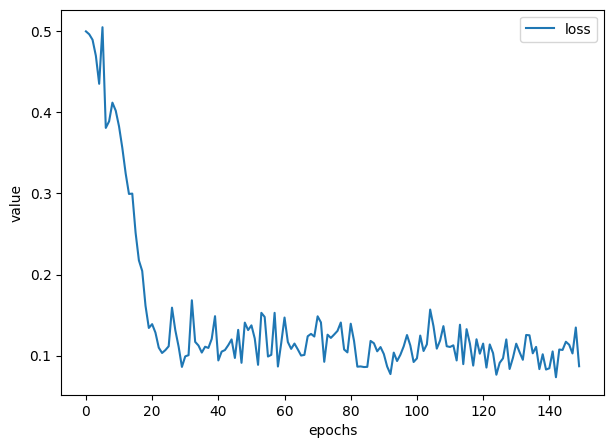

In [9]:
import time
start_tr = time.time()
print('Training.. ')
for step, (input_graph, truth_graph) in zip(range(steps), dataloader):
       
        loss, params, opt_state = make_step(params, input_graph, truth_graph, opt_state)
        epoch_loss = loss
        print('--------------------->  STEP: ', step, ' LOSS: ', epoch_loss)
        loss_list.append(epoch_loss)

end_tr = time.time()

print('tot time: ', end_tr - start_tr)
plt.figure(figsize=(7, 5), dpi=100)
xrange = np.arange(0,steps,1)
plt.plot(xrange, np.asarray(loss_list), label = 'loss')
plt.xlabel('epochs')
plt.ylabel('value')
plt.legend()
plt.show()

In [10]:
print('Post processing ..')

graph_test, graph_truth_test = GetGraphs(arrays_test, batch_size)
predicted_graph = network.apply(params, graph_test)
predicted_radius = predicted_graph.nodes
predicted_radius = np.reshape(predicted_radius, (predicted_radius.shape[0], predicted_radius.shape[1]))
radius = predicted_radius.ravel()
truth = graph_truth_test.nodes.flatten().tolist()

print(radius)

Post processing ..
[0.24779412 0.24779412 0.24779412 ... 0.98559    0.98559    0.98559   ]


(array([  55.,  103.,    0.,   49.,   78.,   63.,    0.,  208.,  340.,
         172.,  401.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1219.]),
 array([0.17888802, 0.18695505, 0.19502206, 0.20308909, 0.2111561 ,
        0.21922313, 0.22729014, 0.23535717, 0.24342418, 0.25149119,
        0.25955823, 0.26762524, 0.27569225, 0.28375927, 0.29182631

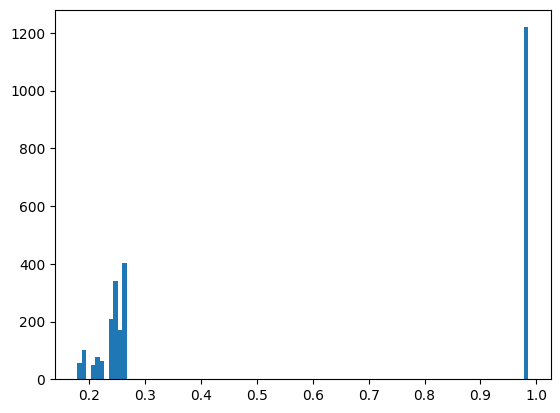

In [13]:
plt.hist(radius, bins=100)

In [32]:
print(graph_truth_test.nodes[0])
print(predicted_graph.nodes[0][:53])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]
[[0.24779412]
 [0.24779412]
 [0.24779412]
 [0.24779412]
 [0.24779543]
 [0.24779543]
 [0.24779388]
 [0.24779412]
 [0.24779543]
 [0.24779388]
 [0.24779543]
 [0.24779388]
 [0.24779621]
 [0.24779621]
 [0.24779388]
 [0.24779388]
 [0.24779388]
 [0.24779543]
 [0.24779543]
 [0.24779543]
 [0.24779543]
 [0.24779388]
 [0.24779543]
 [0.24779543]
 [0.24779543]
 [0.24779543]
 [0.24779388]
 [0.24779388]
 [0.24779388]
 [0.24779543]
 [0.24779543]
 [0.24779543]
 [0.24779388]
 [0.24779543]
 [0.24779543]
 [0.24779543]
 [0.24779543]
 [0.24779388]
 [0.24779543]
 [0.24779543]
 [0.24779543]
 [0.24779543]
 [0.24779543]
 [0.24779543]
 [0.24779543]
 [0.24779543]
 [0.24779543]
 [0.24779543]
 [0.24779543]
 [0.24779388]
 [0.24779543]
 [0.24779543]
 [0.24779543]]


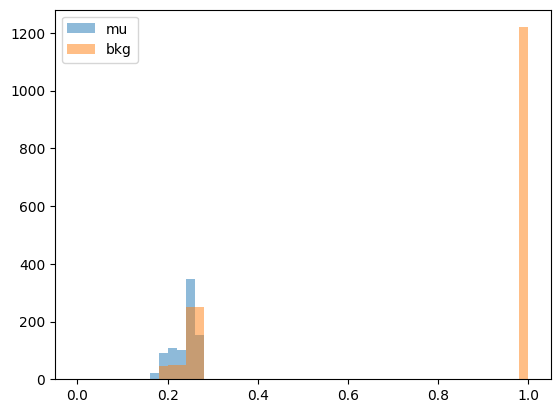

In [15]:


mu = []
bkg = []
for i in range(len(truth)):
    label = truth[i]
    prediction = radius[i]
    if label==1:
        mu.append(prediction)
    else:
        bkg.append(prediction)

plt.hist(mu, bins=50, range=[0,1], label='mu', alpha = 0.5)
plt.hist(bkg, bins=50, range=[0,1], label='bkg', alpha = 0.5)
plt.legend()
plt.show()